### Predicting Diabetes
This dataset originally comes from the National Institute of Diabetes and Digestive and Kidney Diseases. The goal is to predict, based on diagnostic measures, whether or not a patient has diabetes.

In [39]:
# Step 0. Import libraries, custom modules and logging
# Basics ---------------------------------------------------------------
import logging
import joblib
# Data -----------------------------------------------------------------
import pandas as pd
import numpy as np
# Graphics -------------------------------------------------------------
import matplotlib.pyplot as plt
import seaborn as sns
# Machine learning -----------------------------------------------------
from sklearn.model_selection import train_test_split
from sklearn.metrics import (mean_squared_error, 
                             mean_absolute_error,
                             r2_score)
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
# Logging initialization -----------------------------------------------
logger = logging.getLogger()
logger.setLevel(logging.INFO)

In [23]:
# 1 Create data frame
# 1.1 Read from source and get basic info
df_raw = pd.read_csv('https://raw.githubusercontent.com/4GeeksAcademy/decision-tree-project-tutorial/main/diabetes.csv')
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [24]:
df_raw.sample(10, random_state=2024)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
286,5,155,84,44,545,38.7,0.619,34,0
710,3,158,64,13,387,31.2,0.295,24,0
13,1,189,60,23,846,30.1,0.398,59,1
296,2,146,70,38,360,28.0,0.337,29,1
290,0,78,88,29,40,36.9,0.434,21,0
338,9,152,78,34,171,34.2,0.893,33,1
663,9,145,80,46,130,37.9,0.637,40,1
142,2,108,52,26,63,32.5,0.318,22,0
308,0,128,68,19,180,30.5,1.391,25,1
474,4,114,64,0,0,28.9,0.126,24,0


In [25]:
# Step 2. Prepare the dataset for analysis
# 2.1 Make transformations using a pipeline
df_interim = (
    df_raw
    .copy()
    .set_axis(
        df_raw.columns.str.replace(' ','_')
        .str.replace(r'\W','',regex=True)
        .str.lower()
        .str.slice(0,40), axis=1
    )
    .rename(columns={'outcome':'target'})
)
df_interim.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   pregnancies               768 non-null    int64  
 1   glucose                   768 non-null    int64  
 2   bloodpressure             768 non-null    int64  
 3   skinthickness             768 non-null    int64  
 4   insulin                   768 non-null    int64  
 5   bmi                       768 non-null    float64
 6   diabetespedigreefunction  768 non-null    float64
 7   age                       768 non-null    int64  
 8   target                    768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [26]:
df_interim.sample(10)

,pregnancies,glucose,bloodpressure,skinthickness,insulin,bmi,diabetespedigreefunction,age,target
305,2,120,76,37,105,39.7,0.215,29,0
565,2,95,54,14,88,26.1,0.748,22,0
340,1,130,70,13,105,25.9,0.472,22,0
205,5,111,72,28,0,23.9,0.407,27,0
757,0,123,72,0,0,36.3,0.258,52,1
472,0,119,66,27,0,38.8,0.259,22,0
745,12,100,84,33,105,30.0,0.488,46,0
307,0,137,68,14,148,24.8,0.143,21,0
67,2,109,92,0,0,42.7,0.845,54,0
310,6,80,66,30,0,26.2,0.313,41,0


In [27]:
# 2.2 Create the final dataset with the target in front, show result
df = (
    df_interim
    .copy()
    .reindex(
        columns=(
            ['target'] + 
            [c for c in df_interim.columns.to_list() if c not in ['target']]
        )
    )
)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   target                    768 non-null    int64  
 1   pregnancies               768 non-null    int64  
 2   glucose                   768 non-null    int64  
 3   bloodpressure             768 non-null    int64  
 4   skinthickness             768 non-null    int64  
 5   insulin                   768 non-null    int64  
 6   bmi                       768 non-null    float64
 7   diabetespedigreefunction  768 non-null    float64
 8   age                       768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [28]:
# Step 3. Perform EDA
# 3.1 Split the dataset
df_train, df_test = train_test_split(df, 
                                     random_state=2024, 
                                     test_size=0.2)
df_train = df_train.reset_index(drop=True).sort_values(by='target')
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 614 entries, 608 to 1
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   target                    614 non-null    int64  
 1   pregnancies               614 non-null    int64  
 2   glucose                   614 non-null    int64  
 3   bloodpressure             614 non-null    int64  
 4   skinthickness             614 non-null    int64  
 5   insulin                   614 non-null    int64  
 6   bmi                       614 non-null    float64
 7   diabetespedigreefunction  614 non-null    float64
 8   age                       614 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 48.0 KB


In [29]:
# 3.2 Descriptive Statistics
display(df_train.describe(include="number").T)


,count,mean,std,min,25%,50%,75%,max
target,614.0,0.346906,0.476373,0.000,0.000,0.000,1.0000,1.00
pregnancies,614.0,3.801303,3.341801,0.000,1.000,3.000,6.0000,17.00
glucose,614.0,121.402280,32.625455,0.000,99.000,118.000,141.7500,199.00
bloodpressure,614.0,69.456026,20.278257,0.000,64.000,72.000,80.0000,122.00
skinthickness,614.0,20.716612,15.769687,0.000,0.000,23.000,32.7500,63.00
insulin,614.0,80.947883,115.687775,0.000,0.000,34.000,125.0000,744.00
bmi,614.0,32.088111,8.109101,0.000,27.500,32.400,36.6000,67.10
diabetespedigreefunction,614.0,0.478990,0.344910,0.085,0.238,0.365,0.6485,2.42
age,614.0,33.100977,11.722438,21.000,24.000,29.000,40.0000,81.00


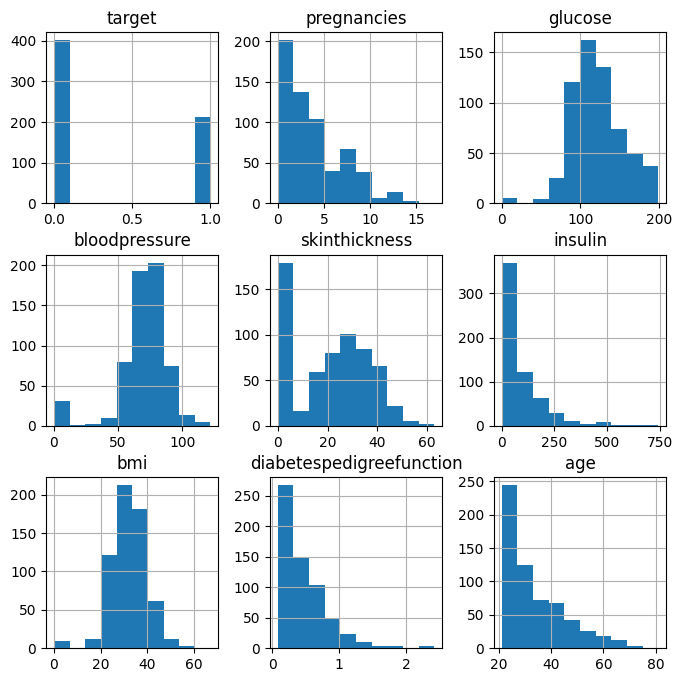

In [30]:
# 3.3 Create univariate analysis- numerical features
df_train.hist(figsize=(8,8))
plt.show()

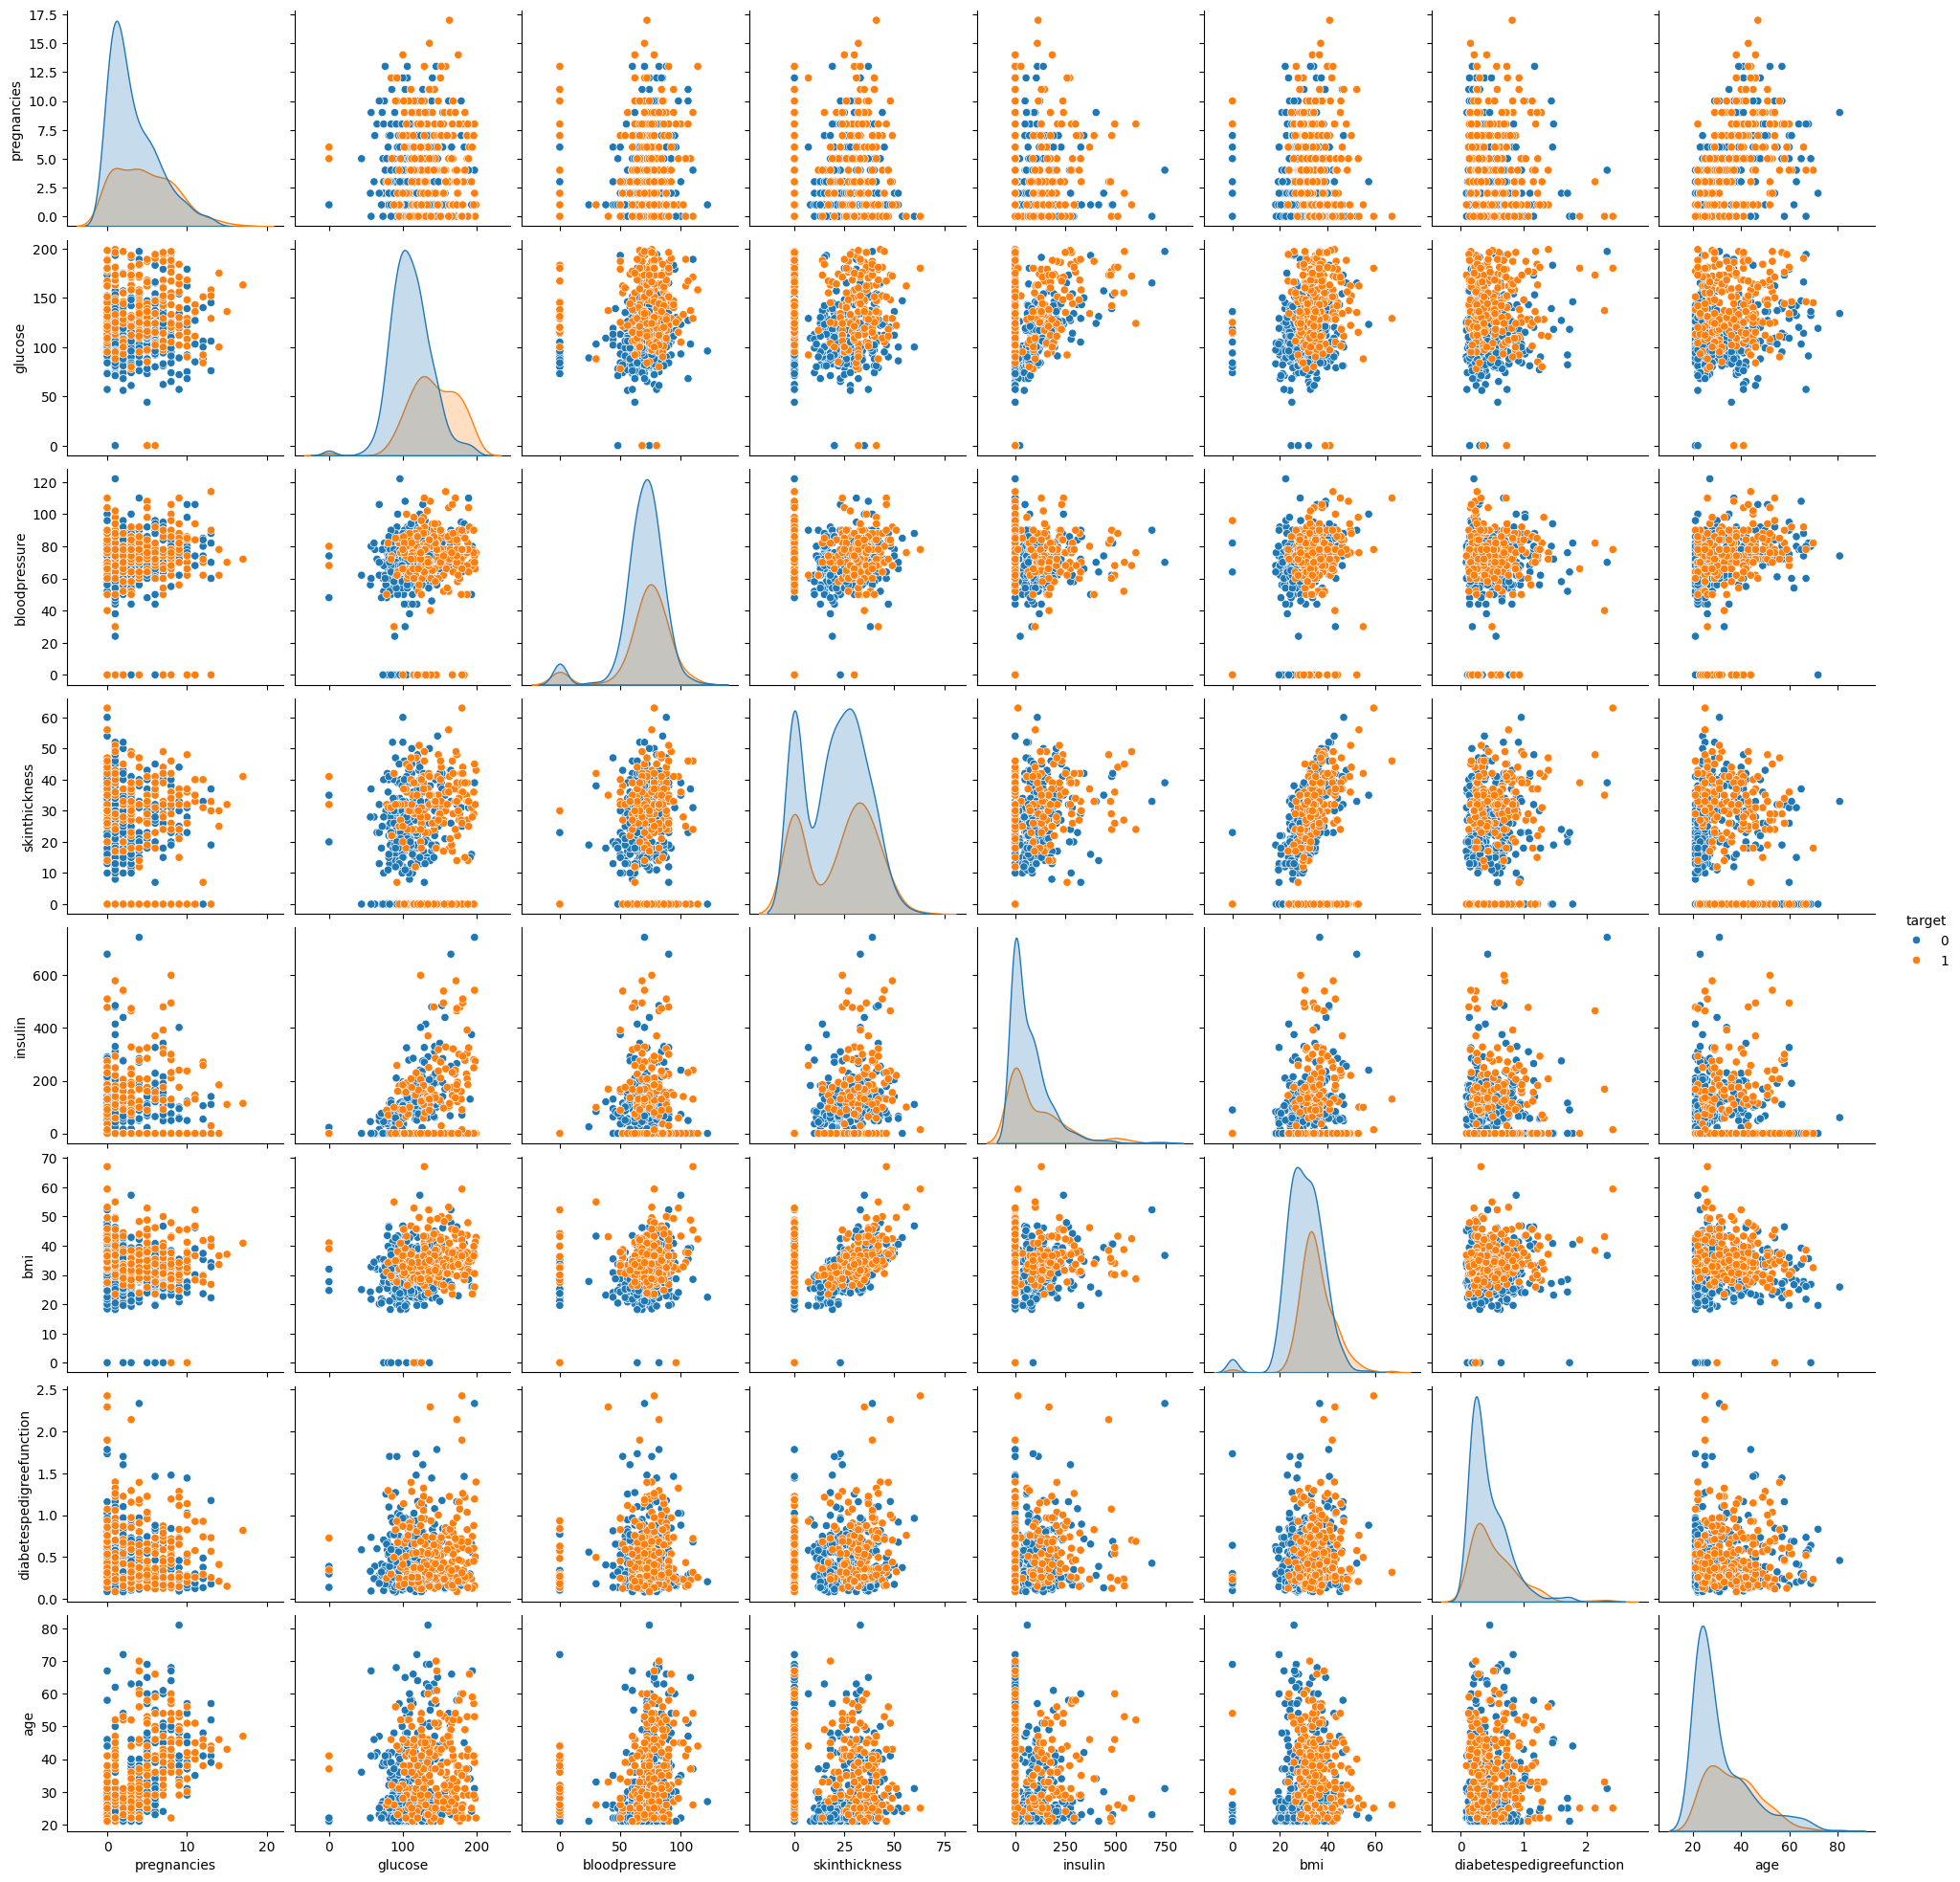

In [31]:
# Análisis bivariado variables numéricas
sns.pairplot(data= df_train, hue= 'target')
plt.show()

In [32]:
df_train.select_dtypes('number').corr()

,target,pregnancies,glucose,bloodpressure,skinthickness,insulin,bmi,diabetespedigreefunction,age
target,1.000000,0.212451,0.446860,0.056212,0.060447,0.120479,0.301577,0.147291,0.223038
pregnancies,0.212451,1.000000,0.103766,0.128565,-0.097094,-0.090141,0.012952,-0.065062,0.557528
glucose,0.446860,0.103766,1.000000,0.160762,0.052897,0.331337,0.235860,0.146675,0.227980
bloodpressure,0.056212,0.128565,0.160762,1.000000,0.204393,0.091765,0.300139,0.031721,0.240959
skinthickness,0.060447,-0.097094,0.052897,0.204393,1.000000,0.448436,0.428181,0.205774,-0.144605
insulin,0.120479,-0.090141,0.331337,0.091765,0.448436,1.000000,0.200205,0.190423,-0.068207
bmi,0.301577,0.012952,0.235860,0.300139,0.428181,0.200205,1.000000,0.143785,0.031198
diabetespedigreefunction,0.147291,-0.065062,0.146675,0.031721,0.205774,0.190423,0.143785,1.000000,0.033151
age,0.223038,0.557528,0.227980,0.240959,-0.144605,-0.068207,0.031198,0.033151,1.000000


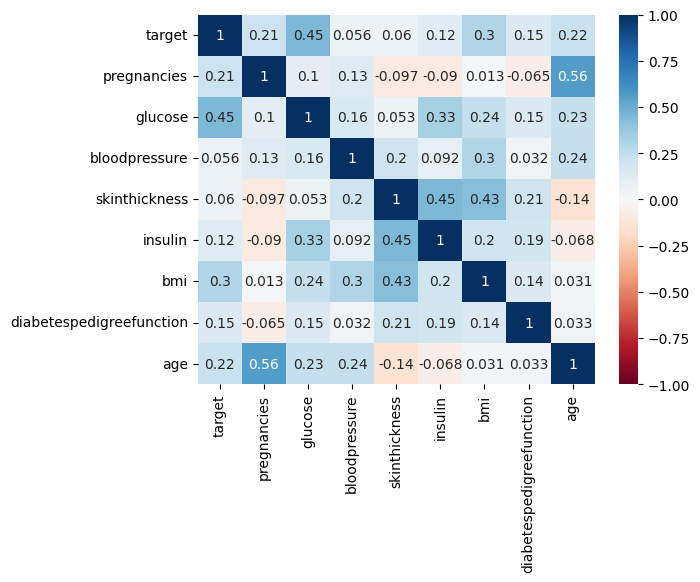

In [33]:
sns.heatmap(df_train.select_dtypes('number').corr(), vmin= -1, vmax= 1, annot= True, cmap="RdBu")
plt.show()

In [34]:
# Step 4. Create a machine learning model
# 4.1 Split features and reponse
X_train = df_train.reset_index(drop=True).drop('target', axis=1)
y_train = df_train['target'].reset_index(drop=True)
X_test = df_test.reset_index(drop=True).drop('target', axis=1)
y_test = df_test['target'].reset_index(drop=True)

In [35]:
dtr = DecisionTreeClassifier()
dtr.fit(X_train,y_train)

DecisionTreeClassifier()

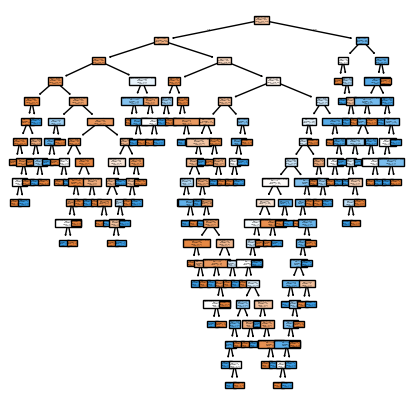

In [43]:

fig = plt.figure(figsize=(5,5))

tree.plot_tree(dtr, feature_names = list(X_train.columns), class_names = ["0", "1"], filled = True)

plt.show()

In [36]:
pred_dtr = dtr.predict(X_test)
pred_dtr

array([1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0,
       0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0,
       1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0,
       1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0,
       0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0,
       1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0])

In [45]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, pred_dtr)

0.6558441558441559